## Mean Reversion TIme series and cross-section, with value as Price/moving average, returns as daily log returns, and Futures data 1 (11 commodities, of energy, metals, cattle, from 2004 to late 2019)

In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import DataReader
import datetime as dt
import matplotlib.pyplot as plt

In [96]:
# Price data
px_c1 = pd.read_excel("futures.xlsx", sheet_name= 'C1')
px_c1 = px_c1['2004-01-05' : '2019-03-06']
px_c2 = pd.read_excel("futures.xlsx", sheet_name= 'C2')
px_c2 = px_c2['2004-01-05' : '2019-03-06']
#data_px.head()

In [123]:
px_c2.head(3)

,CL2 Comdty,QS2 Comdty,HO2 Comdty,HG2 Comdty,LL2 Comdty,LN2 Comdty,LX2 Comdty,GC2 Comdty,PL2 Comdty,SI2 Comdty,LC2 Comdty
2004-01-05,203.92,489.15,226.72,82.76,726.09,16589.98,1495.30,589.64,912.78,8.842,76.686
2004-01-06,203.73,497.92,227.91,81.50,715.31,14755.67,1463.85,587.42,921.72,8.958,75.929
2004-01-07,203.25,492.04,226.17,81.27,708.45,14778.85,1458.13,586.17,914.88,8.867,77.495


In [100]:
from fredapi import Fred
fred = Fred(api_key='7c161acab6738b3fe57d68ce58877860')
CPI = pd.DataFrame(fred.get_series('CPIAUCSL'))
CPI.columns = ['index']

In [101]:
# create index multiplier
CPI['CPI_Multiplier'] = CPI['index'].iloc[-1] / CPI['index']


In [102]:
CPI = CPI.loc[(px_c1.iloc[0].name).replace(day=1) :]
CPI.head(4)

,index,CPI_Multiplier
2004-01-01,186.3,1.384611
2004-02-01,186.7,1.381644
2004-03-01,187.1,1.378691
2004-04-01,187.4,1.376483


In [103]:
s1 = px_c1.join(CPI, how='outer')
s1=s1.drop('index',axis=1)
s1['CPI_Multiplier'] = s1['CPI_Multiplier'].fillna(method='ffill')
columns = list(px_c1.columns) + list(['CPI_Multiplier'])
s1.columns = columns
c1 = s1[columns].multiply(s1['CPI_Multiplier'], axis="index")
c1 = c1.drop(['CPI_Multiplier'],axis=1)
c1 = c1.dropna()

s2 = px_c2.join(CPI, how='outer')
s2=s2.drop('index',axis=1)
s2['CPI_Multiplier'] = s2['CPI_Multiplier'].fillna(method='ffill')
columns2 = list(px_c2.columns) + list(['CPI_Multiplier'])
s2.columns = columns2
c2 = s2[columns2].multiply(s2['CPI_Multiplier'], axis="index")
c2 = c2.drop(['CPI_Multiplier'],axis=1)
c2 = c2.dropna()



In [104]:
def acad_p_returns(c1,c2):
    c2.columns = c1.columns
    lit_returns = c1.subtract(c2.shift(1),axis=0)
    lit_returns = lit_returns.divide(c2.shift(0),axis=0)
    return lit_returns

In [105]:
#Market daily log returns
def returns(c1):
    returns = pd.DataFrame(pd.np.empty((0, len(c1.columns))))
    returns.columns = c1.columns
    for x in returns.columns:
        returns[x] = np.log(c1[x] / c1[x].shift(1))
    return returns
    

In [128]:
#Comparing daily log return with long position reutrn of commodities futures from academic literautre
def compare_ret(c1,c2):
    c2.columns = c1.columns
    bench = pd.DataFrame(pd.np.empty((0, len(c1.columns))))
    bench.columns = c1.columns
    for x in bench:
        bench["Log Return " +x] = returns(c1)[x]
        bench["Academic Paper Return "+x] = acad_p_returns(c1,c2)[x] 
        fig = bench[["Log Return " +x, "Academic Paper Return "+x]].plot(grid=True,figsize=(8,5))
        
        fig = fig.get_figure()
        fig.savefig(str(x)+'.jpg')
        #plt.savefig("%s.png" % text)
        

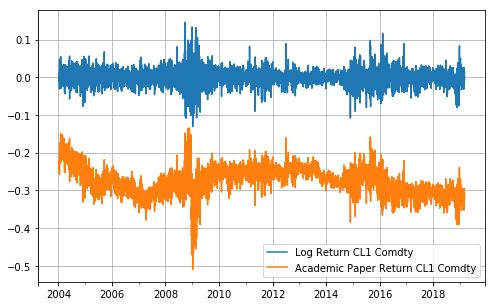

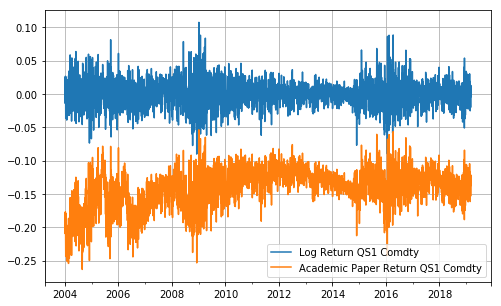

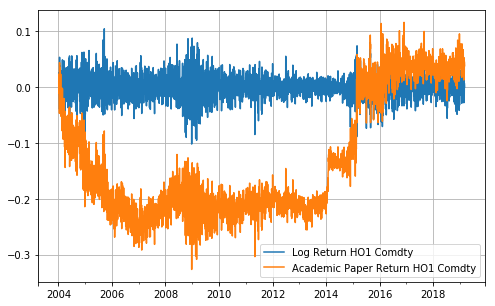

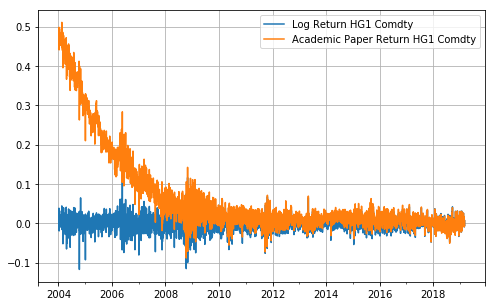

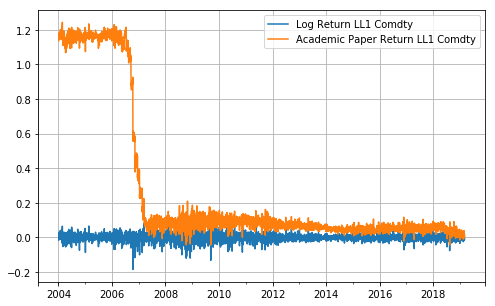

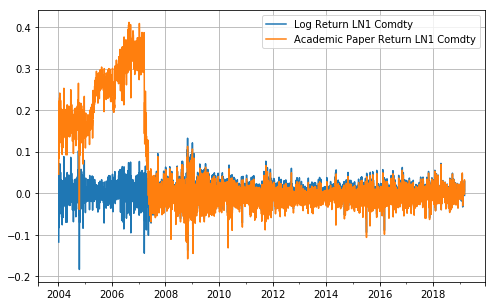

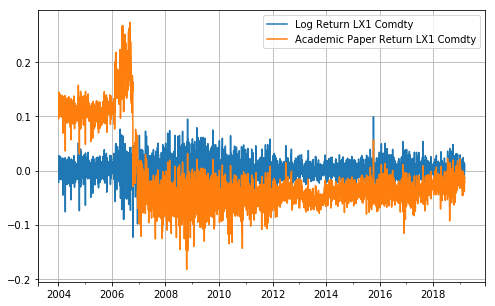

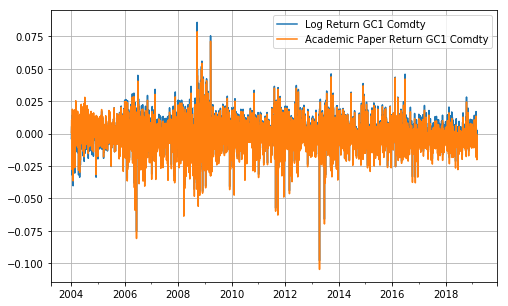

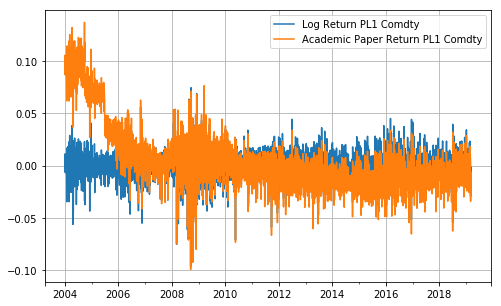

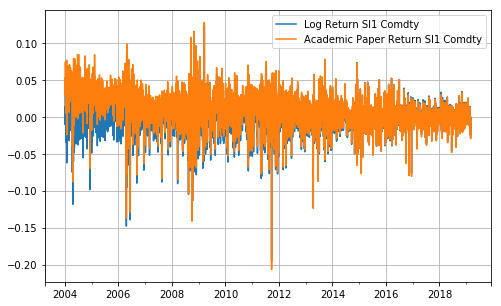

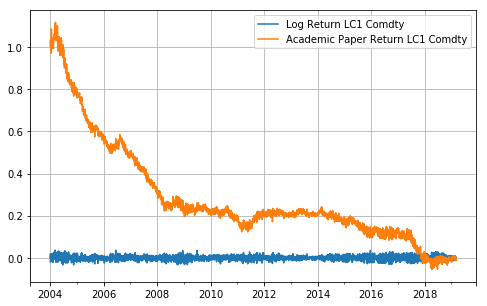

In [129]:
compare_ret(c1,c2)

In [130]:
def time_series_signal_long_and_longshort(px,y):
    ma_df = pd.DataFrame(pd.np.empty((0, len(px.columns))))
    ma_df = px.rolling(window=252*y).mean()
    ma_df.columns = px.columns
    signal_df = pd.DataFrame(pd.np.empty((0, len(px.columns))))
    signal_df.columns = px.columns
    for x in signal_df:
        signal_df[x] = np.where(px[x]<=ma_df[x],1,-1)
    signal_df.index = px.index
    signal_df_long = pd.DataFrame(pd.np.empty((0, len(px.columns))))
    signal_df_long.columns = px.columns
    for x in signal_df_long:
        signal_df_long[x] = np.where(px[x]<=ma_df[x],1,0)
    signal_df_long.index = px.index
    return_long_short = signal_df.shift(1) * returns(px)
    return_long = signal_df_long.shift(1) * returns(px)
    print("TIME SERIES")
    print("LONG_SHORT Returns")       
    print(return_long_short.sum())
    print("TOTAL RETURN  ", return_long_short.sum().sum())
    print("")
    print("LONG ONLY Returns")
    print(return_long.sum())
    print("TOTAL RETURN  ", return_long.sum().sum())


    bench = pd.DataFrame(pd.np.empty((0, len(px.columns))))
    bench.columns = px.columns
    for x in bench.columns:
        bench["Market " +x] = returns(px)[x]
        bench["Long-Short Model "+x] = return_long_short[x] 
        bench["Long Only Model "+x] = return_long[x] 
        fig = bench[["Market " +x,"Long-Short Model "+x,"Long Only Model "+x ]].cumsum().plot(grid=True,figsize=(8,5))
        fig = fig.get_figure()
        fig.savefig(str(x)+'.jpg')
 
    
    return return_long_short, return_long

TIME SERIES
LONG_SHORT Returns
CL1 Comdty   -1.602897
QS1 Comdty   -0.750415
HO1 Comdty    1.273165
HG1 Comdty    0.685009
LL1 Comdty    1.925516
LN1 Comdty    1.262990
LX1 Comdty    0.694731
GC1 Comdty   -0.669776
PL1 Comdty    0.387800
SI1 Comdty   -0.442248
LC1 Comdty    0.331730
dtype: float64
TOTAL RETURN   3.095603784118077

LONG ONLY Returns
CL1 Comdty   -1.382668
QS1 Comdty   -0.355146
HO1 Comdty    0.480033
HG1 Comdty    0.637785
LL1 Comdty    0.973397
LN1 Comdty    0.305105
LX1 Comdty    0.415451
GC1 Comdty   -0.087610
PL1 Comdty   -0.041190
SI1 Comdty   -0.111151
LC1 Comdty   -0.108160
dtype: float64
TOTAL RETURN   0.7258452708736532


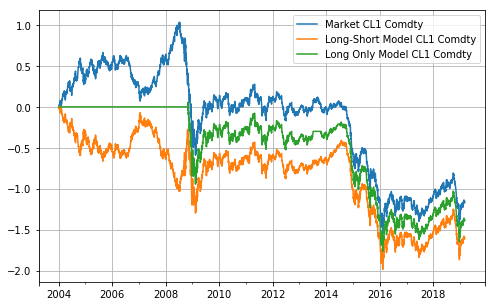

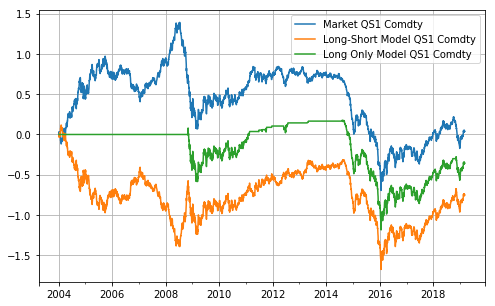

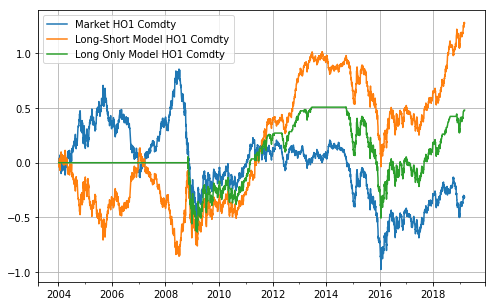

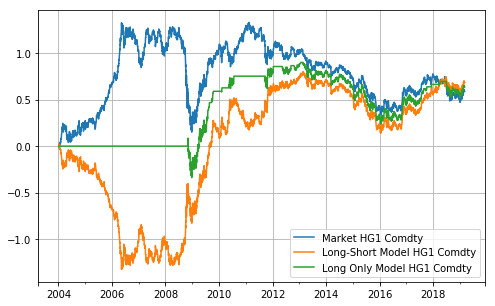

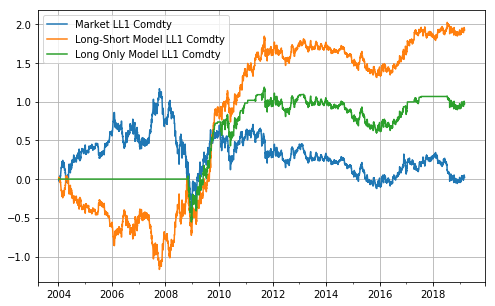

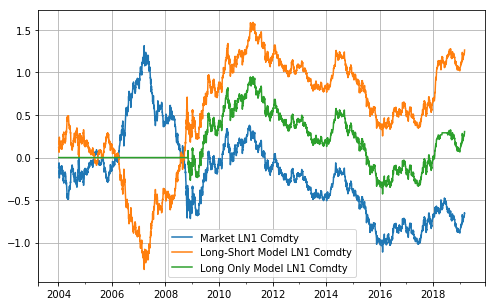

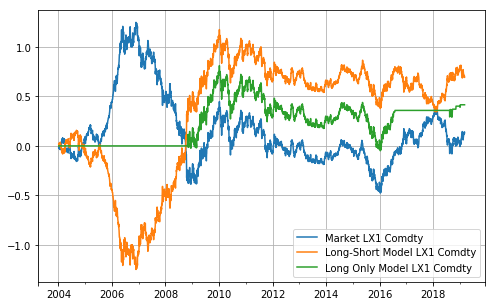

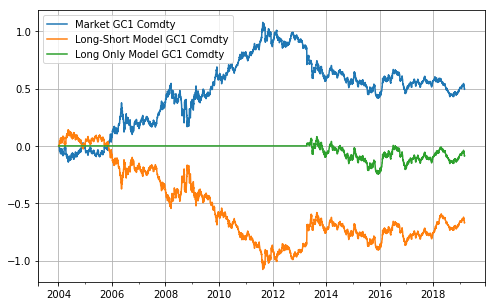

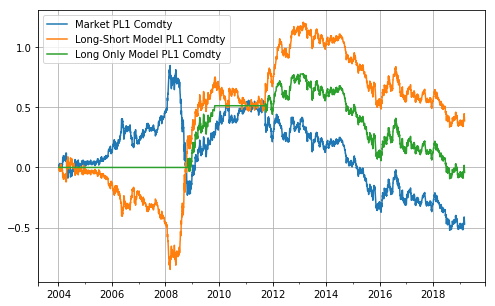

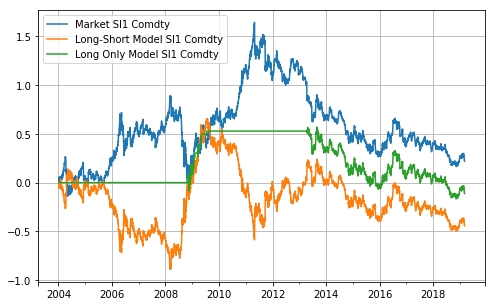

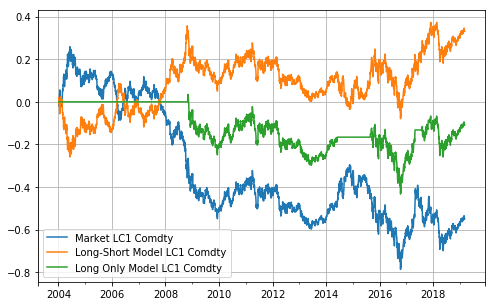

In [131]:
(long_short, long) = time_series_signal_long_and_longshort(c1,5)

In [91]:
#cross - section 

In [132]:
def cross_section__signal_long_and_longshort(px,y, ):
    cross_ma = pd.DataFrame(pd.np.empty((0, len(px.columns))))
    cross_ma = px / px.rolling(window=256*y).mean()
    cross_ma = cross_ma.dropna()
    cross_ma.columns = px.columns
    ranks = cross_ma.rank(axis=1, ascending=False)
    ranks.index = cross_ma.index
    
    signal_df_long_short = pd.DataFrame(index=ranks.index,columns = ranks.columns )
    for x in ranks.index:
        signal_df_long_short.loc[x] = np.where(ranks.loc[x]<int(len(px.columns)/3)+1,-1,0)
        signal_df_long_short.loc[x] = np.where(ranks.loc[x]>int(len(px.columns)/3)*2,1, signal_df_long_short.loc[x])
    signal_df_long_short.index = cross_ma.index
    
    signal_df_long = pd.DataFrame(index=ranks.index,columns = ranks.columns )
    for x in ranks.index:
        signal_df_long.loc[x] = np.where(ranks.loc[x]>int(len(px.columns)/3)*2,1, 0)
    signal_df_long.index = cross_ma.index
    
    return_long_short = signal_df_long_short.shift(1) * returns(px)
    return_long = signal_df_long.shift(1) * returns(px)

    print("CROSS SECTION")
    print("LONG_SHORT Returns")       
    print(return_long_short.sum())
    print("TOTAL RETURN  ", return_long_short.sum().sum())
    print("")
    print("LONG ONLY Returns")
    print(return_long.sum())
    print("TOTAL RETURN  ", return_long.sum().sum())

    bench = pd.DataFrame(pd.np.empty((0, len(px.columns))))
    bench.columns = px.columns
    for x in bench.columns:
        bench["Market " +x] = returns(px)[x]
        bench["Long-Short Model "+x] = return_long_short[x] 
        bench["Long Only Model "+x] = return_long[x] 
        fig = bench[["Market " +x,"Long-Short Model "+x,"Long Only Model "+x ]].cumsum().plot(grid=True,figsize=(8,5))
        fig = fig.get_figure()
        fig.savefig(str(x)+'.jpg')
 
    
    return return_long_short, return_long

CROSS SECTION
LONG_SHORT Returns
CL1 Comdty   -0.621003
QS1 Comdty    1.124053
HO1 Comdty    1.407130
HG1 Comdty    0.413598
LL1 Comdty    0.296058
LN1 Comdty    0.949115
LX1 Comdty    0.419474
GC1 Comdty   -0.313760
PL1 Comdty   -0.388916
SI1 Comdty   -1.076180
LC1 Comdty    0.076144
dtype: float64
TOTAL RETURN   2.285713151053549

LONG ONLY Returns
CL1 Comdty   -0.710195
QS1 Comdty    0.693733
HO1 Comdty    0.840311
HG1 Comdty    0.256950
LL1 Comdty    0.174858
LN1 Comdty    0.678597
LX1 Comdty    0.333520
GC1 Comdty    0.020353
PL1 Comdty   -0.350544
SI1 Comdty   -0.391421
LC1 Comdty   -0.061590
dtype: float64
TOTAL RETURN   1.484572051437727


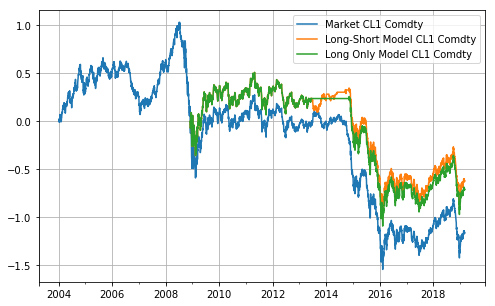

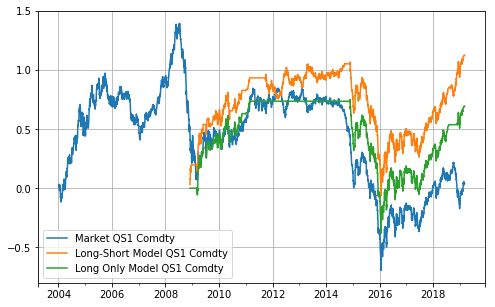

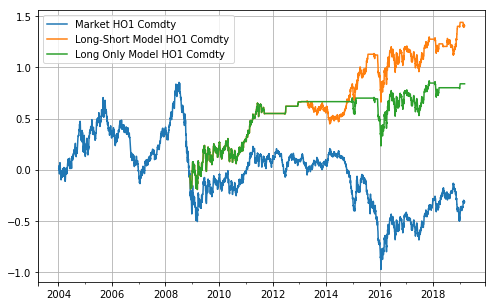

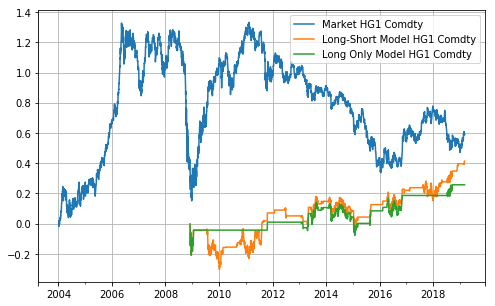

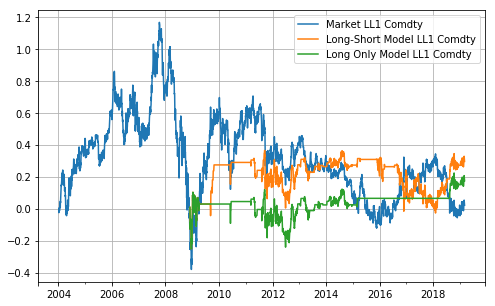

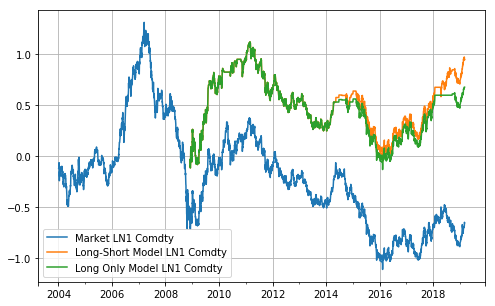

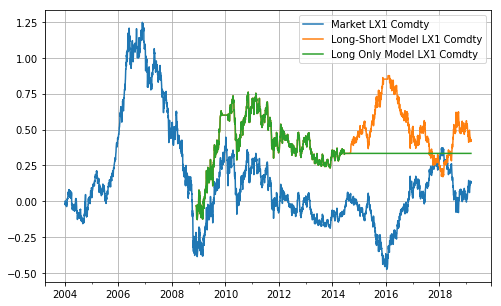

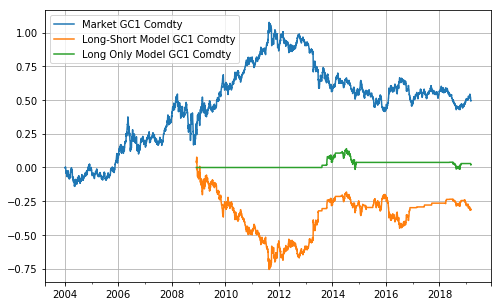

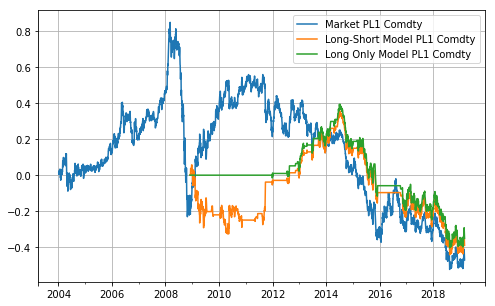

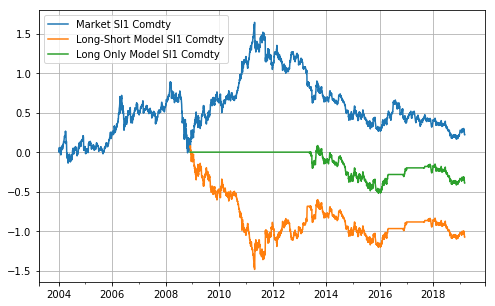

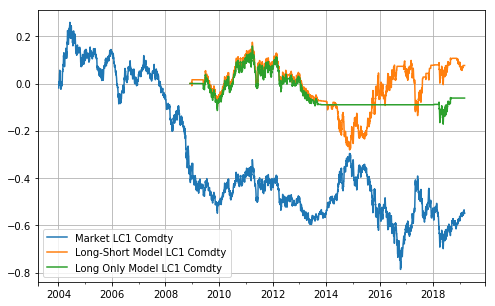

In [133]:
(long_short, long) = cross_section__signal_long_and_longshort(c1,5)

In [116]:
#acad return
def time_series_signal_long_and_longshort_acad_ret(px,c2,y):
    ma_df = pd.DataFrame(pd.np.empty((0, len(px.columns))))
    ma_df = px.rolling(window=252*y).mean()
    ma_df.columns = px.columns
    signal_df = pd.DataFrame(pd.np.empty((0, len(px.columns))))
    signal_df.columns = px.columns
    for x in signal_df:
        signal_df[x] = np.where(px[x]<=ma_df[x],1,-1)
    signal_df.index = px.index
    signal_df_long = pd.DataFrame(pd.np.empty((0, len(px.columns))))
    signal_df_long.columns = px.columns
    for x in signal_df_long:
        signal_df_long[x] = np.where(px[x]<=ma_df[x],1,0)
    signal_df_long.index = px.index
    return_long_short = signal_df.shift(1) * acad_p_returns(px,c2)
    return_long = signal_df_long.shift(1) * acad_p_returns(px,c2)
    print("TIME SERIES")
    print("LONG_SHORT Returns")       
    print(return_long_short.sum())
    print("TOTAL RETURN  ", return_long_short.sum().sum())
    print("")
    print("LONG ONLY Returns")
    print(return_long.sum())
    print("TOTAL RETURN  ", return_long.sum().sum())


    bench = pd.DataFrame(pd.np.empty((0, len(px.columns))))
    bench.columns = px.columns
    for x in bench.columns:
        bench["Market " +x] = returns(px)[x]
        bench["Long-Short Model "+x] = return_long_short[x] 
        bench["Long Only Model "+x] = return_long[x] 
        fig = bench[["Market " +x,"Long-Short Model "+x,"Long Only Model "+x ]].cumsum().plot(grid=True,figsize=(8,5))
        fig = fig.get_figure()
 
    
    return return_long_short, return_long

TIME SERIES
LONG_SHORT Returns
CL1 Comdty   -332.144385
QS1 Comdty     74.919370
HO1 Comdty    170.740196
HG1 Comdty   -222.611032
LL1 Comdty   -822.316206
LN1 Comdty   -221.912727
LX1 Comdty   -138.289046
GC1 Comdty     -1.133882
PL1 Comdty    -58.804980
SI1 Comdty    -32.192441
LC1 Comdty   -426.767723
dtype: float64
TOTAL RETURN   -2010.5128552824988

LONG ONLY Returns
CL1 Comdty   -710.786177
QS1 Comdty   -242.086489
HO1 Comdty   -176.070527
HG1 Comdty     21.522713
LL1 Comdty    128.411094
LN1 Comdty    -17.423170
LX1 Comdty    -91.520760
GC1 Comdty     -3.559306
PL1 Comdty    -18.454280
SI1 Comdty      1.948679
LC1 Comdty    354.744027
dtype: float64
TOTAL RETURN   -753.2741970987746


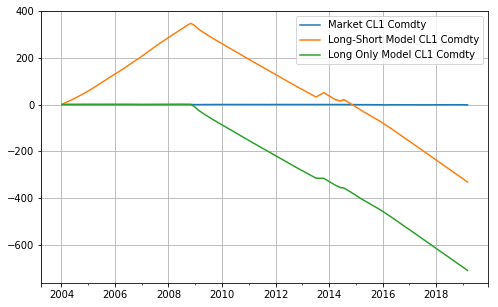

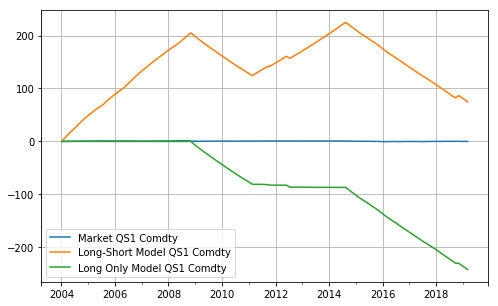

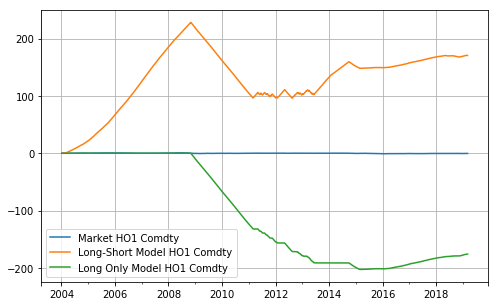

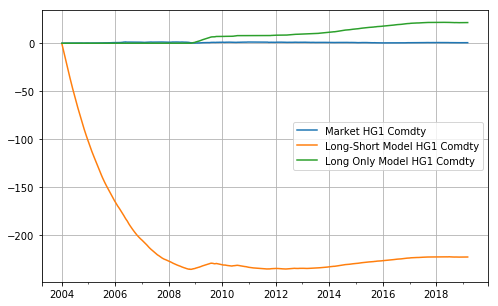

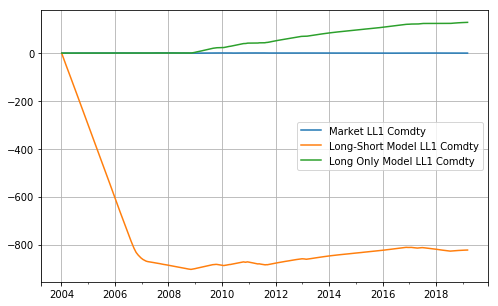

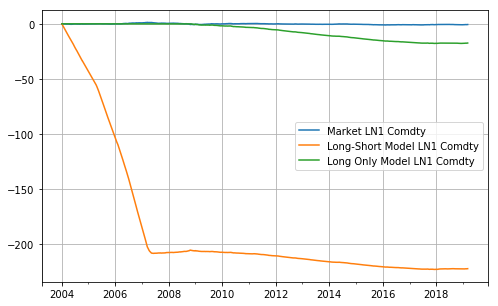

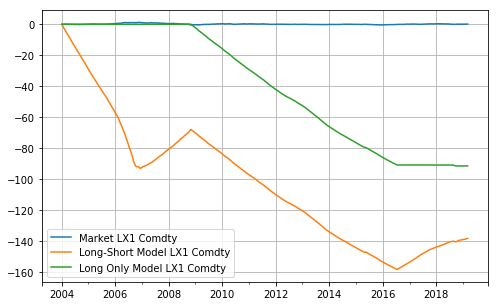

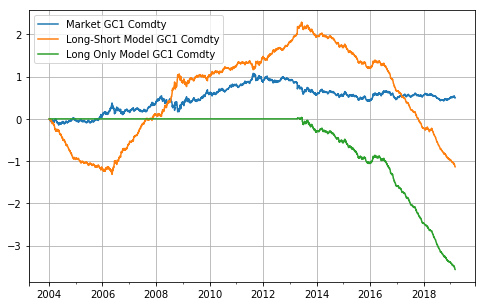

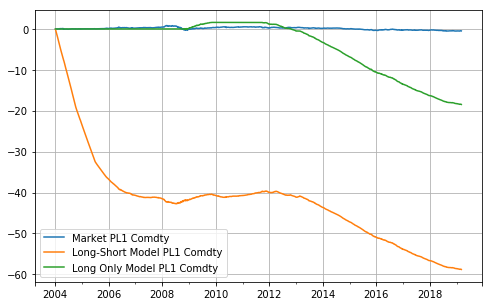

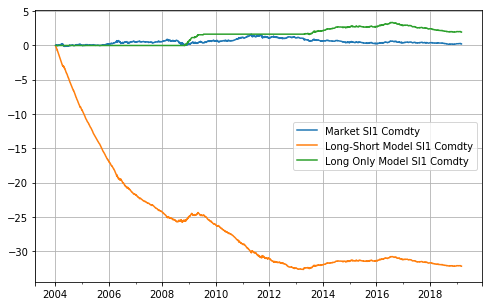

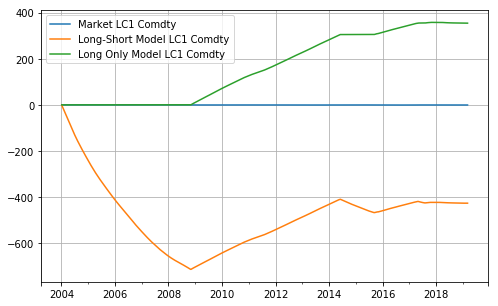

In [118]:
(long_short, long) = time_series_signal_long_and_longshort_acad_ret(c1,c2,5)

In [121]:
#Acad retur
def cross_section__signal_long_and_longshort_acad(px,c2, y, ):
    cross_ma = pd.DataFrame(pd.np.empty((0, len(px.columns))))
    cross_ma = px / px.rolling(window=256*y).mean()
    cross_ma = cross_ma.dropna()
    cross_ma.columns = px.columns
    ranks = cross_ma.rank(axis=1, ascending=False)
    ranks.index = cross_ma.index
    
    signal_df_long_short = pd.DataFrame(index=ranks.index,columns = ranks.columns )
    for x in ranks.index:
        signal_df_long_short.loc[x] = np.where(ranks.loc[x]<int(len(px.columns)/3)+1,-1,0)
        signal_df_long_short.loc[x] = np.where(ranks.loc[x]>int(len(px.columns)/3)*2,1, signal_df_long_short.loc[x])
    signal_df_long_short.index = cross_ma.index
    
    signal_df_long = pd.DataFrame(index=ranks.index,columns = ranks.columns )
    for x in ranks.index:
        signal_df_long.loc[x] = np.where(ranks.loc[x]>int(len(px.columns)/3)*2,1, 0)
    signal_df_long.index = cross_ma.index
    
    return_long_short = signal_df_long_short.shift(1) * acad_p_returns(px,c2)
    return_long = signal_df_long.shift(1) * acad_p_returns(px,c2)

    print("CROSS SECTION")
    print("LONG_SHORT Returns")       
    print(return_long_short.sum())
    print("TOTAL RETURN  ", return_long_short.sum().sum())
    print("")
    print("LONG ONLY Returns")
    print(return_long.sum())
    print("TOTAL RETURN  ", return_long.sum().sum())

    bench = pd.DataFrame(pd.np.empty((0, len(px.columns))))
    bench.columns = px.columns
    for x in bench.columns:
        bench["Market " +x] = returns(px)[x]
        bench["Long-Short Model "+x] = return_long_short[x] 
        bench["Long Only Model "+x] = return_long[x] 
        fig = bench[["Market " +x,"Long-Short Model "+x,"Long Only Model "+x ]].cumsum().plot(grid=True,figsize=(8,5))
        fig = fig.get_figure()
 
    
    return return_long_short, return_long

CROSS SECTION
LONG_SHORT Returns
CL1 Comdty   -584.063220
QS1 Comdty    -69.283157
HO1 Comdty    -69.071740
HG1 Comdty      0.939993
LL1 Comdty     20.945843
LN1 Comdty    -13.740128
LX1 Comdty    -28.363668
GC1 Comdty      1.962057
PL1 Comdty    -13.232464
SI1 Comdty     -8.936861
LC1 Comdty     91.823850
dtype: float64
TOTAL RETURN   -671.0194955544704

LONG ONLY Returns
CL1 Comdty   -634.619295
QS1 Comdty   -174.457785
HO1 Comdty   -135.909053
HG1 Comdty      6.429841
LL1 Comdty     51.710181
LN1 Comdty    -14.126648
LX1 Comdty    -65.084643
GC1 Comdty     -0.367923
PL1 Comdty    -12.547997
SI1 Comdty      0.903962
LC1 Comdty    213.099911
dtype: float64
TOTAL RETURN   -764.9694488754424


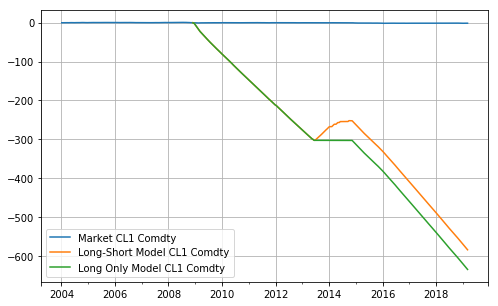

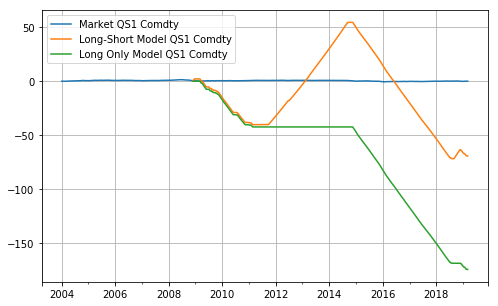

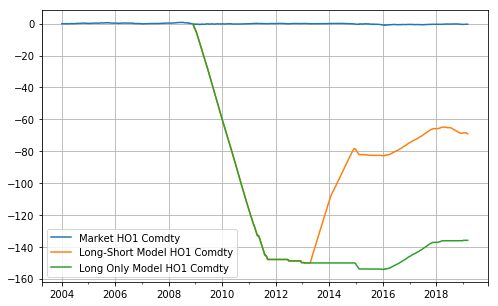

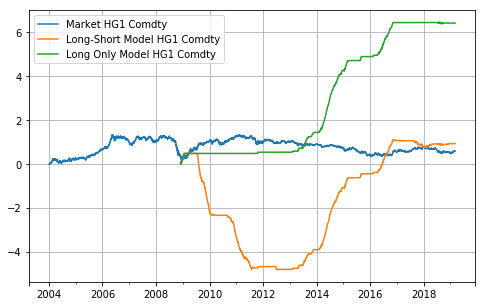

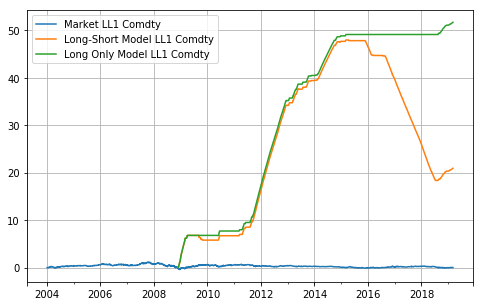

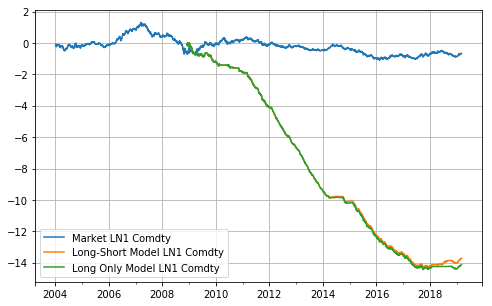

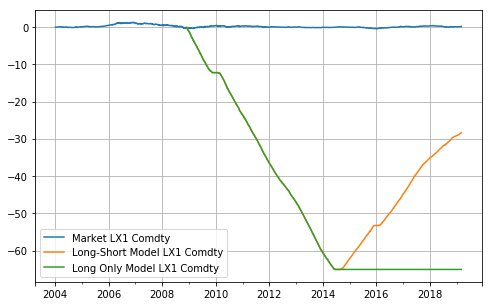

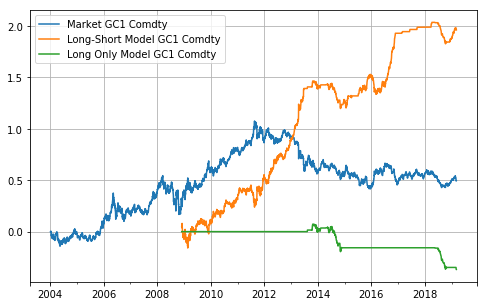

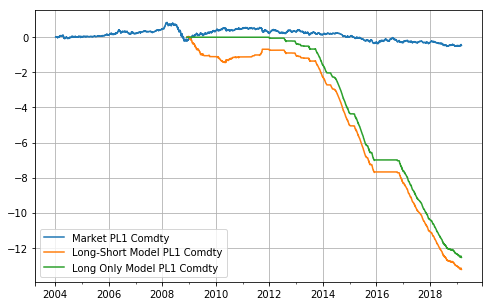

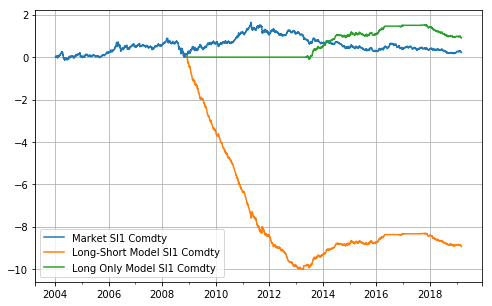

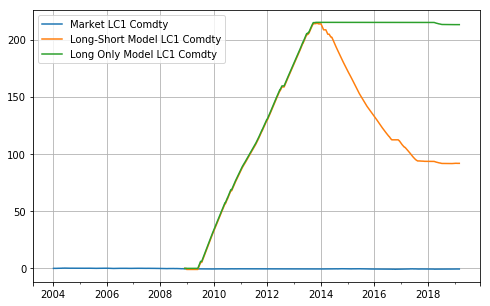

In [122]:
(long_short, long) = cross_section__signal_long_and_longshort_acad(c1,c2,5)

In [134]:
#y=months

def heat_cross_section__signal_long_and_longshort(px,y, f):
    cross_ma = pd.DataFrame(pd.np.empty((0, len(px.columns))))
    cross_ma = px / px.rolling(window=21*y).mean()
    cross_ma = cross_ma.dropna()
    cross_ma.columns = px.columns
    ranks = cross_ma.rank(axis=1, ascending=False)
    ranks.index = cross_ma.index
    
    signal_df_long_short = pd.DataFrame(index=ranks.index,columns = ranks.columns )
    for x in ranks.index:
        signal_df_long_short.loc[x] = np.where(ranks.loc[x]<int(len(px.columns)*f),-1,0)
        signal_df_long_short.loc[x] = np.where(ranks.loc[x]>int(len(px.columns)*(1-f)),1, signal_df_long_short.loc[x])
    signal_df_long_short.index = cross_ma.index
    

    
    return_long_short = signal_df_long_short.shift(1) * returns(px)


    r = return_long_short.sum().sum()


    return r

In [137]:
import numpy as np
from collections import defaultdict
months = range(12, 60, 6) 
weight = np.arange(0.1, 1, 0.1)
dd = defaultdict(dict)
for y in months:
    for f in weight:
        dd[y][f] = heat_cross_section__signal_long_and_longshort(c1,y, f)
        ddf = pd.DataFrame(dd)
        ddf.index.name = 'Signal Weight' 
        ddf.columns.name = 'Lookback Period in Months'

In [138]:
import matplotlib.pyplot as plt
def heatmap(df, cmap=plt.cm.hot):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    axim = ax.imshow(df.values, cmap=cmap, interpolation='nearest') 
    ax.set_xlabel(df.columns.name) 
    ax.set_xticks(np.arange(len(df.columns))) 
    ax.set_xticklabels(list(df.columns)) 
    ax.set_ylabel(df.index.name) 
    ax.set_yticks(np.arange(len(df.index))) 
    ax.set_yticklabels(list(df.index))
    plt.colorbar(axim)
    fig.savefig('HEATMAP1.jpg')

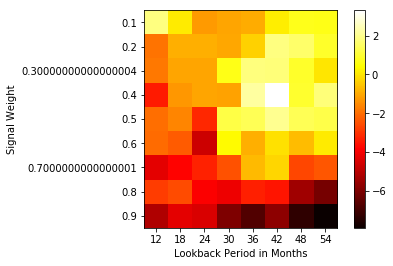

In [139]:
heatmap(ddf)